<a href="https://colab.research.google.com/github/matheusrbg/Reconhecimento-do-Alfabeto-em-Libras/blob/main/vgg19bn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms
from torch.optim import lr_scheduler
from torch.utils.data.sampler import SubsetRandomSampler
import time
import os
import copy
import matplotlib.pyplot as plt

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
use_gpu = (device == 'cuda')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/LIBRAS/train.zip -d /content/drive/MyDrive/LIBRAS/

Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/MyDrive/LIBRAS/train/U/956.png  
  inflating: /content/drive/MyDrive/LIBRAS/train/U/957.png  
  inflating: /content/drive/MyDrive/LIBRAS/train/U/958.png  
  inflating: /content/drive/MyDrive/LIBRAS/train/U/959.png  
  inflating: /content/drive/MyDrive/LIBRAS/train/U/96.png  
  inflating: /content/drive/MyDrive/LIBRAS/train/U/960.png  
  inflating: /content/drive/MyDrive/LIBRAS/train/U/961.png  
  inflating: /content/drive/MyDrive/LIBRAS/train/U/962.png  
  inflating: /content/drive/MyDrive/LIBRAS/train/U/963.png  
  inflating: /content/drive/MyDrive/LIBRAS/train/U/964.png  
  inflating: /content/drive/MyDrive/LIBRAS/train/U/965.png  
  inflating: /content/drive/MyDrive/LIBRAS/train/U/966.png  
  inflating: /content/drive/MyDrive/LIBRAS/train/U/967.png  
  inflating: /content/drive/MyDrive/LIBRAS/train/U/968.png  
  inflating: /content/drive/MyDrive/LIBRAS/train/U/969.png  
  inflating: /content/drive/MyDrive

# Preprocessing

In [ ]:
transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.1),
        transforms.RandomAffine(degrees=40, translate=None, scale=(1, 2), shear=15),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

In [ ]:
train_path = "/content/drive/MyDrive/LIBRAS/train"
test_path = "/content/drive/MyDrive/LIBRAS/test"
valid_size = 0.1


test_dataset = datasets.ImageFolder(
    root=test_path,
    transform=transform
)

train_dataset = datasets.ImageFolder(
    root=train_path,
    transform=transform
)

num_train = len(train_dataset)
indices = list(range(num_train))
split = int(np.floor(valid_size * num_train))

train_idx, valid_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    num_workers=1,
    batch_size=64,
    sampler=train_sampler
)
 
valid_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=64,
    num_workers=1,
    sampler=valid_sampler
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=64,
    num_workers=1,
    shuffle=True
)

FileNotFoundError: ignored

# Visualizing

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
    
def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[label[x] for x in classes])

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    
    # Set model for evaluation
    model.train(False)
    model.eval() 
    
    images_so_far = 0

    for i, data in enumerate(test_loader):
        inputs, labels,_ = data
        size = inputs.size()[0]
        
        if use_gpu:
            with torch.no_grad():
                inputs, labels = inputs.cuda(), labels.cuda()
        else:
            with torch.no_grad():
                inputs, labels = inputs, labels
        
        outputs = model(inputs)
        
        _, preds = torch.max(outputs.data, 1)
        predicted_labels = [preds[j] for j in range(inputs.size()[0])]
        
        print("Ground truth:")
        show_databatch(inputs.data.cpu(), labels.data.cpu())
        print("Prediction:")
        show_databatch(inputs.data.cpu(), predicted_labels)
        
        del inputs, labels, outputs, preds, predicted_labels
        torch.cuda.empty_cache()
        
        images_so_far += size
        if images_so_far >= num_images:
            break
        
    model.train(mode=was_training)

# Evaluating

In [ ]:
def eval_model(model, criterion):
    y_true = []
    y_pred = []
    vid_id = []
    since = time.time()
    avg_loss = 0
    avg_acc = 0
    loss_test = 0
    acc_test = 0
    
    test_batches = len(test_loader)
    print("Evaluating model")
    print('-' * 10)
    
    for i, data in enumerate(test_loader):
        if i % 100 == 0:
            print("\rTest batch {}/{}".format(i, test_batches), end='', flush=True)

        model.train(False)
        model.eval()
        
        inputs, labels, fname = data
        
        for f in fname:
            vid_id.append(f.split('/')[-1].split('.')[0].split('_')[0])
        y_true = y_true + labels.tolist()
        
        if use_gpu:
            with torch.no_grad():
                inputs, labels = inputs.cuda(), labels.cuda()
        else:
            with torch.no_grad():
                inputs, labels = inputs, labels

        outputs = model(inputs)

        _, preds = torch.max(outputs.data, 1)
        loss = criterion(outputs, labels)
        #print(preds)
        y_pred = y_pred + preds.tolist()
        
        loss_test += loss.item()
        acc_test += torch.sum(preds == labels.data)

        del inputs, labels, outputs, preds
        torch.cuda.empty_cache()
        
    avg_loss = loss_test / len(test_dataset)
    avg_acc = acc_test / len(test_dataset)
    
    elapsed_time = time.time() - since
    print()
    print("Evaluation completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Avg loss (test): {:.4f}".format(avg_loss))
    print("Avg acc (test): {:.4f}".format(avg_acc))
    print('-' * 10)

# Training

In [ ]:
def train_model(vgg, criterion, optimizer, scheduler, num_epochs=5):
    since = time.time()
    best_model_wts = copy.deepcopy(vgg.state_dict())
    best_acc = 0.0
    
    avg_loss = 0
    avg_acc = 0
    avg_loss_val = 0
    avg_acc_val = 0
    
    train_batches = len(train_loader)
    
    loss_values = []
    acc_values = []
    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs))
        print('-' * 10)
        
        loss_train = 0
        loss_val = 0
        acc_train = 0
        
        vgg.train(True)
        
        for i, data in enumerate(train_loader):
            
            print("\rTraining batch {}/{}".format(i+1, train_batches), end='', flush=True)
                
            
                
            inputs, labels,_= data
            
            if use_gpu:
                with torch.no_grad():
                    inputs, labels = inputs.cuda(), labels.cuda()
            else:
                with torch.no_grad():
                    inputs, labels = inputs, labels
            
            optimizer.zero_grad()
            
            outputs = vgg(inputs)
            
            _, preds = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            loss_train += loss.item()
            acc_train += torch.sum(preds == labels.data)
            
            del inputs, labels, outputs, preds
            torch.cuda.empty_cache()
        
        print()
        # * 2 as we only used half of the dataset
        avg_loss = loss_train  / len(train_dataset)
        avg_acc = acc_train  / len(train_dataset)
        loss_values.append(avg_loss)
        acc_values.append(avg_acc)
        vgg.train(False)
        vgg.eval()
            

        
        print()
        print("Epoch {} result: ".format(epoch))
        print("Avg loss (train): {:.4f}".format(avg_loss))
        print("Avg acc (train): {:.4f}".format(avg_acc))

        print('-' * 10)
        print()
        
        if avg_acc > best_acc:
            best_acc = avg_acc
            best_model_wts = copy.deepcopy(vgg.state_dict())
        
    elapsed_time = time.time() - since
    print()
    print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Best acc: {:.4f}".format(best_acc))
    
    vgg.load_state_dict(best_model_wts)
    return vgg,acc_values,loss_values

In [ ]:
num_classes = len(os.listdir(train_path))
num_epochs = 10
batch_size = 64
learning_rate = 0.0005

model = torchvision.models.vgg19_bn(weights="IMAGENET1K_V1").to(device)

# Newly created modules have require_grad=True by default
num_features = model.classifier[6].in_features
features = list(model.classifier.children())[:-1] # Remove last layer
features.extend([nn.Linear(num_features, num_classes)]) # Add our layer with 4 outputs
model.classifier = nn.Sequential(*features) # Replace the model classifier

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)  

# Train the model
total_step = len(train_loader)

C:\Users\bianc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [ ]:
visualize_model(model)

In [ ]:
model,acc,loss = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=10)
torch.save(model.state_dict(),'VGG19_libras.pt')

In [ ]:
eval_model(model, criterion)

Text(0.5, 1.0, 'VGG loss')

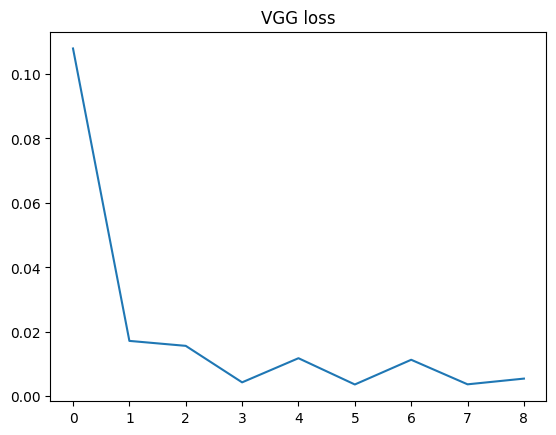

In [ ]:
plt.plot([it.item() for it in loss[:-1]])
plt.title("VGG loss")